In [326]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Let's quickly fit the CIV line (and ignore continuum fitting etc for this example)

In [324]:
def gaussian(x, m, sigma, k):
    sigma = (sigma / c) * m
    g = k * np.exp(-.5 * ((x - m) / sigma)**2)
    return g

def gaussian3(x, m, sigma1, k1, sigma2, k2, sigma3, k3):
    gauss = gaussian(x, m, sigma1, k1) + gaussian(x, m, sigma2, k2) + gaussian(x, m, sigma3, k3)
    return gauss

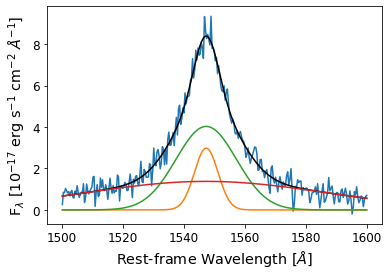

In [325]:
with fits.open('/home/ray/Downloads/spec-7572-56944-0012.fits') as spec:
    flux = spec[1].data['flux'] - 3  # I'm subtracting 3 instead of doing continuum subtraction, this is just for convenience in this notebook!!
    z = spec[2].data['Z']
    wav = 10**spec[1].data['loglam'] / (1 + z)
    c = 3 * 10**5
    
    ix = (wav > 1500) & (wav < 1600)
    
    p0 = [1549, 500, 100, 1000, 100, 10000, 100]
    bounds = [[1500, 0, 0, 0, 0, 0, 0], [1600, np.inf, 1000, np.inf, 1000, np.inf, 1000]]
    pf, cov = curve_fit(gaussian3, wav[ix], flux[ix], p0 = p0, bounds = bounds)
    
    plt.plot(wav[ix], flux[ix])
    plt.plot(wav[ix], gaussian3(wav[ix], *pf), 'k-')
    plt.plot(wav[ix], gaussian(wav[ix], *pf[[0, 1, 2]]))
    plt.plot(wav[ix], gaussian(wav[ix], *pf[[0, 3, 4]]))
    plt.plot(wav[ix], gaussian(wav[ix], *pf[[0, 5, 6]]))
    plt.ylabel(r'F$_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
    plt.xlabel(r'Rest-frame Wavelength [$\AA$]')

The BH mass equation is written in Shen+ (2011) Eqn 2:
$$
\log\left(\frac{M_{BH}}{M_\odot}\right) = a + b \log\left(\frac{\lambda L_\lambda}{10^{44} \text{erg s}^{-1}}\right) + 2 \log\left(\frac{\text{FWHM}}{\text{km s}^{-1}}\right)
$$
where, for CIV
$$
(a, b) = (0.660,0.53)\\
$$

To get our quantities, let's start keeping better track of units:

In [329]:
from astropy.cosmology import Planck15 as cosmo
import astropy.constants as const
import astropy.units as u

civ_wav = np.linspace(1500, 1600, 1000)
civ_flux = gaussian3(civ_wav, *pf)

distance = cosmo.luminosity_distance(z).to('cm')  # Distance to the quasar, used shortly
civ_flux = civ_flux * 10**-17 * u.erg / u.s / u.cm / u.cm / u.Angstrom
civ_wav = civ_wav * u.Angstrom

Then the full width at half max can be calculated and converted to km/s, and we'll plot where it finds the half max to be:

FWHM: 18.100009371386705 Angstrom
FWHM: 3506.9237124414744 km / s


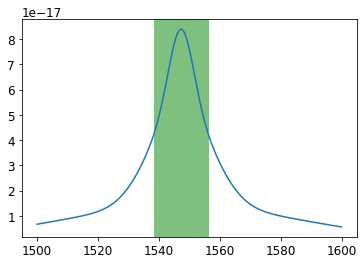

In [330]:
from scipy.interpolate import UnivariateSpline
    
def FWHM(x, y):
    spline = UnivariateSpline(x, y - y.max()/2, s=0)
    r1, r2 = spline.roots()
    return abs(r1 - r2), r1, r2

def angstrom_to_kms(fwhm, mu):
    return const.c * fwhm / mu

fwhm, left, right = FWHM(civ_wav, civ_flux)
fwhm = fwhm * u.Angstrom
fwhm_kms = angstrom_to_kms(fwhm, pf[0] * u.Angstrom)

plt.plot(civ_wav, civ_flux)
plt.axvspan(left, right, facecolor='g', alpha=0.5)

print('FWHM:', fwhm)
print('FWHM:', fwhm_kms.to('km/s'))

Next let's calculate the line luminosity, $L_{CIV}$. 

For CIV, Eqn 14 gives:
$$
\log\left(\frac{L_{1350}}{\text{erg s}^{-1}}\right) = (7.66 \pm 0.41) + (0.863 \pm 0.009) \log\left(\frac{L_{CIV}}{\text{erg s}^{-1}}\right)
$$

First we'll need to convert the spectral flux to a spectral luminosity, using the distance to the quasar.

In [331]:
civ_lum = civ_flux * (4 * np.pi * distance**2)

Then we can integrate the line using np.trapz, which I place in a function called calc_LCIV

In [332]:
def calc_LCIV(wav, lum):
    return np.trapz(lum, wav)

LCIV = calc_LCIV(civ_wav, civ_lum)
print('LCIV:', LCIV)

LCIV: 1.028777654093495e+44 cm2 erg / (cm2 s)


And finally, using the equation above, I calculate $L_{1350}$:

In [333]:
def calc_L1350(LCIV):
    return 10**(7.66 + 0.863 * np.log10(LCIV / (u.erg / u.s))) * u.erg / u.s

L1350 = calc_L1350(LCIV)
print('L1350:', L1350)

L1350: 4.3917081744065123e+45 erg / s


I scratched my head for a little bit about units at this point. The BH mass equation has a $\lambda L_\lambda$ term, and it turns out that $L_{1350} = \lambda L_\lambda \big\rvert_{1350}$ here. So we can just plug it into our equation, and can calculate the BH mass:

In [334]:
def calc_Mbh(lum, fwhm, a=0.660, b=0.53):
    return 10**(a + b*np.log10(lum / (1e44 * u.erg/u.s)) + 2*np.log10(fwhm / (u.km / u.s))) * u.solMass

In [335]:
Mbh = calc_Mbh(L1350, fwhm_vel)
print('log(Mbh):', np.log10(Mbh / u.solMass))
print('Mbh:', Mbh)

log(Mbh): 8.620448378345579
Mbh: 417299993.8829843 solMass


Which is a very reasonable value!